In [1]:
import os,sys,inspect
import hydra
import omegaconf
import torch
from omegaconf import DictConfig

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0,parentdir)

from models import AE
from src import mvtec_loader as mloader

from pytorch_lightning import Trainer
from pytorch_lightning.callbacks import LearningRateMonitor
from pytorch_lightning.callbacks import EarlyStopping, ModelCheckpoint 
import torchvision as tv

import numpy as np
from src import utils
import matplotlib.colors as mcolors
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from torch.nn import functional as F

from matplotlib import pyplot as plt
import matplotlib.image as mpimg

import numpy as np

from sklearn.cluster import DBSCAN
from sklearn import metrics
from sklearn.datasets import make_blobs
from sklearn.preprocessing import StandardScaler

from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score, mean_squared_error

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import math


import pytorch_lightning
pytorch_lightning.__version__

'1.4.0'

In [2]:
#change to function load model
cfg = omegaconf.OmegaConf.load('../config/config.yaml')

In [3]:
transform  = tv.transforms.Compose([tv.transforms.ToPILImage(),
                                    tv.transforms.Resize((cfg.arch.cnn_enc.input_height, cfg.arch.cnn_enc.input_width)),
                                    tv.transforms.ToTensor(), 
                                   ])

loader = mloader.MVTecADDataset(data_root='../data/mvtec_anomaly_detection', 
                                      results_root=os.path.join('../', cfg.exp.results_path, '_' + cfg.exp.run_id),
                                      targets=['bottle', 'transistor', 'hazelnut'], 
                                      create_or_load=True,
                                      reprod=True,
                                      idx_file='idx_' + cfg.exp.run_id, #+ '_split.pkl',
                                      targets_file='targets_' + cfg.exp.run_id, # + '.pkl',
                                      transforms=transform,
                                      batch_size=1,
                                      val_ratio=0.0,
                                      num_workers=cfg.data.num_workers)

targets to be used are:  bottle,transistor,hazelnut


In [4]:
model = AE.AE.load_from_checkpoint('./model_ae.ckpt', args=cfg)

In [5]:
def emulate_drift(loader, mse_avg, eps, burnin_skip=10, max_clusters=8):
    model.eval()

    representations = []
    labels = []
    data_drift = []
    pcs = []
    cluster_number = 1
    reconstr = []

    for image in loader:
        # 0 no drift, 1 - reconstruction error, 2 - new class
        drift = 0
        X, L = image
        labels.append(L.tolist())
        flattened_X = X.view(X.shape[0], -1)
        embedding = model.encoder(flattened_X).data.flatten().tolist()
        representations.append(embedding)

        reconstruction = model(flattened_X).view(X.shape[0], -1)
        mse = mean_squared_error(reconstruction.cpu().detach().numpy(), flattened_X.cpu().detach().numpy())
        reconstr.append((reconstruction, mse))

        if mse - mse_avg > eps:
            drift = 1

        if (len(representations) < burnin_skip):
            data_drift.append(drift)
            continue

        x = StandardScaler().fit_transform(representations)
        pca = PCA(n_components=2)
        principalComponents = pca.fit_transform(x)
        pcs.append(principalComponents)

        nc = 2
        clusterer = KMeans(n_clusters=nc, random_state=10)
        cluster_labels = clusterer.fit_predict(principalComponents)
        best_sil_coef = silhouette_score(x, cluster_labels)

        for i in range(3, max_clusters):
            clusterer = KMeans(n_clusters=i, random_state=10)
            cluster_labels = clusterer.fit_predict(principalComponents)
            sil_coef = silhouette_score(x, cluster_labels)
            if sil_coef > best_sil_coef:
                nc, best_sil_coef = i, sil_coef    

        if nc != cluster_number:
            drift = 2
            cluster_number = nc

        data_drift.append(drift)
        
    return representations, reconstr, labels, data_drift, pcs

In [6]:
# From training
mse_avg = 0.0028

# 
eps = 0.001

test_repr, test_reconstr, test_labels, test_dd, test_pcs = emulate_drift(loader.test_dataloader(), mse_avg, eps)

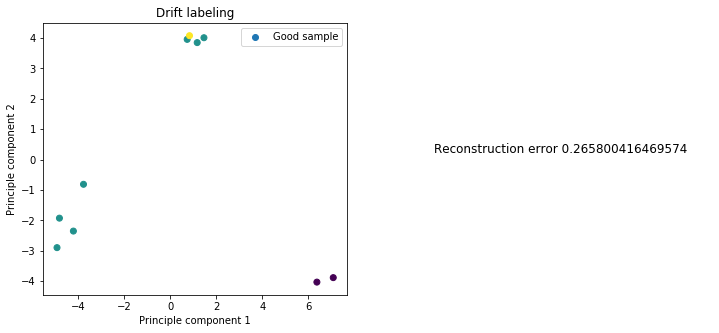

In [72]:
import itertools

import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np


# init the figure
fig = plt.figure(figsize=(12,5))
ax1 = plt.subplot(1,2,1)   
ax2 = plt.subplot(1,2,2)


def update(i):
    # clear the axis each frame
    ax1.clear()

    ax1.set_xlabel('Principle component 1')
    ax1.set_ylabel('Principle component 2')
    ax1.set_title('Drift labeling')

    # replot things
    pc1 = test_pcs[i][:, 0]
    pc2 = test_pcs[i][:, 1]

    ax1.scatter(pc1, pc2, c=test_dd[:10+i])
    ax1.legend(['Good sample', 'Reconstruction error', 'New class'])
    
    ax2.clear()
    ax2.axis('off')
    r, mse = test_reconstr[i]
    ax2.imshow(r.detach().numpy(),interpolation='none')
    ax2.set_title(f'Reconstruction error {mse}')

ani = animation.FuncAnimation(fig, update, frames=len(test_pcs), interval=150)

In [73]:
from IPython.display import HTML
HTML(ani.to_html5_video())

In [74]:
dd = np.array(test_dd)
print(f"Total amount of objects {len(dd)}\nTotal accuracy on test data {1 - (dd == 0).sum()/(len(dd))}")

Total amount of objects 293
Total accuracy on test data 0.757679180887372


![title](./images/Ver1.png)

## Highlights

- Main metric to evaluate approach: "sensitivity" needs to be quantified properly
- Batch size, burning_skip, eps can be used as hyperparameters


## Critique

- Working on simple task
- Does not scale on data size: Current solution stores all (representations, but still) data it has encountered

## Further steps:
- Fix drawing reconstruction
- Check current approach for BMW data/some harder task
- Check out GMM Mixture model as clustering algorithm instead of KMeans to quantify uncertainty.
- Train autoencoder on each class to provide "average" look for every class introduced. Create ensemble algorithm for data drift
- Think about how we can use VAE and its' uncertainty to gain performance
- Look into VAEGAN approach

- Formalise encoders' performance
- Formalise clustering algorithm performance